In [1]:
import mediapipe as mp
import matplotlib.pyplot as plt
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from rembg import remove
from PIL import Image
import numpy as np

## Parameters

In [2]:
mediapipe_model_path = '../hand_landmarker.task'
mediapipe_gesture_recognizer_model_path = '../gesture_recognizer.task'
RGB_image_directory = '../../resources/evaluation_dataset/RGB'
RGB_ground_truth_directory = '../../resources/evaluation_dataset/RGB_annotation'
IR_image_directory = '../../resources/evaluation_dataset/IR'
IR_ground_truth_directory = '../../resources/evaluation_dataset/IR_annotations'
bad_score_penalty = 1
distance_threshold = 0.05

## Create Models

In [3]:
base_options= python.BaseOptions(model_asset_path=mediapipe_model_path)
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
landmark_detector = vision.HandLandmarker.create_from_options(options)

In [4]:
base_options = python.BaseOptions(model_asset_path=mediapipe_gesture_recognizer_model_path)
# classifier_options = vision.ImageClassifierOptions(category_allowlist=["Open_Palm", "None"],
#                                                    score_threshold=0.3,
#                                                    max_results=2,)

options = vision.GestureRecognizerOptions(base_options=base_options,
                                          num_hands=2)

options.canned_gesture_classifier_options.score_threshold = 0
gesture_recognizer = vision.GestureRecognizer.create_from_options(options)

## Drawing Landmarks

In [5]:
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

In [6]:
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image_from_json(rgb_image, evaluation_result):
  hand_landmarks_list = evaluation_result['landmarks']
  # handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    # handedness = handedness_list[idx]
    height, width, _ = annotated_image.shape
    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=float(landmark['x']), y=float(landmark['y']), z=0.0) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
   
    x_coordinates = [landmark['x'] for landmark in hand_landmarks]
    y_coordinates = [landmark['y'] for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"Left",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

## Assessing the Accuracy

In [7]:
def calculate_accuracy(ground_truth, prediction, threshold):
    if prediction is None:  # Missing landmark
        return 0.0
    distance = np.sqrt((float(ground_truth["x"]) - prediction.x) ** 2 + 
                       (float(ground_truth["y"]) - prediction.y) ** 2)
    return max(0, 1 - distance / threshold) * 100

In [8]:
from itertools import permutations

def calculate_hand_accuracies(ground_truth_hands, predicted_hands, handedness_info, threshold):
    accuracies = {"Left": [], "Right": []}

    # If no hands detected, accuracy is 0% for both hands
    if len(predicted_hands) == 0:
        return {"Left": [0.0]*21, "Right": [0.0]*21}
    

    first_predicted_hand = predicted_hands[0]

    hand_accuracy_1 = [
        calculate_accuracy(gt_landmark, pred_landmark, threshold)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[0], first_predicted_hand)
    ]

    hand_accuracy_2 = [
        calculate_accuracy(gt_landmark, pred_landmark, threshold)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[1], first_predicted_hand)
    ]

    if len(predicted_hands) == 1 and sum(hand_accuracy_1) > sum(hand_accuracy_2):
        accuracies["Left"] = hand_accuracy_1
        accuracies["Right"] = [0.0]*21
        return accuracies
    elif len(predicted_hands) == 1:
        accuracies["Right"] = hand_accuracy_2
        accuracies["Left"] = [0.0]*21
        return accuracies
    else:
        second_predicted_hand = predicted_hands[1]
        hand_accuracy_3 = [
            calculate_accuracy(gt_landmark, pred_landmark, threshold)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[0], second_predicted_hand)
        ]

        hand_accuracy_4 = [
            calculate_accuracy(gt_landmark, pred_landmark, threshold)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[1], second_predicted_hand)
        ]

        if sum(hand_accuracy_1) + sum(hand_accuracy_4) > sum(hand_accuracy_2) + sum(hand_accuracy_3):
            accuracies["Left"] = hand_accuracy_1
            accuracies["Right"] = hand_accuracy_4
        else:
            accuracies["Right"] = hand_accuracy_2
            accuracies["Left"] = hand_accuracy_3

    return accuracies

In [9]:
def assess_accuracy(image_path, ground_truth_hands):
    """
    Assess accuracy of predictions for a given image.
    """
    image = mp.Image.create_from_file(image_path)
    
    results = landmark_detector.detect(image)
    
    if not results.hand_landmarks or len(results.hand_landmarks) == 0:
        print(f"No hands detected for {image_path}")
        return {"Left": [0.0]*21, "Right": [0.0]*21}

    return calculate_hand_accuracies(
        ground_truth_hands,
        results.hand_landmarks,
        results.handedness,
        distance_threshold
    )

## Calculating Distance and Average Sum of Distance for the Dataset

In [10]:
def calculate_euclidean_distance(ground_truth, prediction):
    distance = np.sqrt((float(ground_truth["x"]) - prediction.x) ** 2 + 
                       (float(ground_truth["y"]) - prediction.y) ** 2)
    return distance

In [11]:
def calculate_sum_of_distances(ground_truth_hands, predicted_hands):
    distances = {"Left": [], "Right": []}
    if len(predicted_hands) == 0:
        return sum([bad_score_penalty*21]) + sum([bad_score_penalty*21])
    
    if len(predicted_hands) == 1:
        print("Only one hand detected")

    first_predicted_hand = predicted_hands[0]

    hand_distances_1 = [
        calculate_euclidean_distance(gt_landmark, pred_landmark)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[0], first_predicted_hand)
    ]

    hand_distances_2 = [
        calculate_euclidean_distance(gt_landmark, pred_landmark)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[1], first_predicted_hand)
    ]

    if len(predicted_hands) == 1 and sum(hand_distances_1) < sum(hand_distances_2):
        distances["Left"] = sum(hand_distances_1)
        distances["Right"] = sum([bad_score_penalty*21])
    elif len(predicted_hands) == 1:
        distances["Right"] = sum(hand_distances_2)
        distances["Left"] = sum([bad_score_penalty*21])
    else:
        second_predicted_hand = predicted_hands[1]
        hand_distances_3 = [
            calculate_euclidean_distance(gt_landmark, pred_landmark)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[0], second_predicted_hand)
        ]

        hand_distances_4 = [
            calculate_euclidean_distance(gt_landmark, pred_landmark)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[1], second_predicted_hand)
        ]

        if sum(hand_distances_1) + sum(hand_distances_4) < sum(hand_distances_2) + sum(hand_distances_3):
            distances["Left"] = sum(hand_distances_1)
            distances["Right"] = sum(hand_distances_4)
        else:
            distances["Right"] = sum(hand_distances_2)
            distances["Left"] = sum(hand_distances_3)
            
    

    return distances["Left"] + distances["Right"]

In [12]:
def calculate_sum_of_distances_for_image(image_path, ground_truth_hands):
    image = mp.Image.create_from_file(image_path)
    results = landmark_detector.detect(image)
    distance = calculate_sum_of_distances(ground_truth_hands, results.hand_landmarks)
    
    return distance

In [13]:
def calculate_distances(ground_truth_hands, predicted_hands):
    distances = {"Left": [], "Right": []}
    if len(predicted_hands) == 0:
        return {"Left": [bad_score_penalty] * 21, "Right": [bad_score_penalty] * 21 }
    
    if len(predicted_hands) == 1:
        print("Only one hand detected")

    first_predicted_hand = predicted_hands[0]

    hand_distances_1 = [
        calculate_euclidean_distance(gt_landmark, pred_landmark)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[0], first_predicted_hand)
    ]

    hand_distances_2 = [
        calculate_euclidean_distance(gt_landmark, pred_landmark)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[1], first_predicted_hand)
    ]

    if len(predicted_hands) == 1 and sum(hand_distances_1) < sum(hand_distances_2):
        distances["Left"] = hand_distances_1
        distances["Right"] = [bad_score_penalty] * 21
    elif len(predicted_hands) == 1:
        distances["Right"] = hand_distances_2
        distances["Left"] = [bad_score_penalty] * 21
    else:
        second_predicted_hand = predicted_hands[1]
        hand_distances_3 = [
            calculate_euclidean_distance(gt_landmark, pred_landmark)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[0], second_predicted_hand)
        ]

        hand_distances_4 = [
            calculate_euclidean_distance(gt_landmark, pred_landmark)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[1], second_predicted_hand)
        ]

        if sum(hand_distances_1) + sum(hand_distances_4) < sum(hand_distances_2) + sum(hand_distances_3):
            distances["Left"] = hand_distances_1
            distances["Right"] = hand_distances_4
        else:
            distances["Right"] = hand_distances_2
            distances["Left"] = hand_distances_3
            
    return distances

In [14]:
# def calculate_avg_sum_of_distances(image_path, ground_truth_hands):
#     image = mp.Image.create_from_file(image_path)
#     
#     results = landmark_detector.detect(image)
# 
#     if not results.hand_landmarks or len(results.hand_landmarks) == 0:
#         print(f"No hands detected for {image_path}")
#         return {"Left": [bad_score_penalty]*21, "Right": [bad_score_penalty]*21}
#     
#     distances = calculate_sum_of_distances(ground_truth_hands, results.hand_landmarks)
# 
#     return distances["Left"] + distances["Right"]/22.0

In [15]:
def calculate_avg_distance_for_image(image_path, ground_truth_hands):
    image = mp.Image.create_from_file(image_path)
    results = landmark_detector.detect(image)
    distances = calculate_distances(ground_truth_hands, results.hand_landmarks)
    
    return sum(distances["Left"] + distances["Right"]) / len(distances["Left"] + distances["Right"])

In [16]:
def calculate_distances_for_image(image_path, ground_truth_hands):
    image = mp.Image.create_from_file(image_path)
    results = landmark_detector.detect(image)
    distances = calculate_distances(ground_truth_hands, results.hand_landmarks)
    
    return distances["Left"] + distances["Right"]

## Creating Thresholds/Bounds


In [17]:
def calculate_final_accuracy(scores):
    all_scores = scores["Left"] + scores["Right"]
    return sum(all_scores) / len(all_scores) if all_scores else 0.0

In [18]:
import os
import json

def calculate_bound_accuracy(image_directory, ground_truth_directory):
    total_bound = {"Left": [], "Right":[]}
    for file_name in os.listdir(ground_truth_directory):
        if file_name.endswith('.json'):
            json_file_path = os.path.join(ground_truth_directory, file_name)
            
            with open(json_file_path, 'r') as f:
                ground_truth_data = json.load(f)
                
            for entry in ground_truth_data:
                image_name = entry["image"]
                ground_truth_landmarks = entry["landmarks"]
                image_path = os.path.join(image_directory, image_name)
    
                # Assess accuracy for RGB images (upper bound)
                score = assess_accuracy(image_path, ground_truth_landmarks)
                
                for hand in ["Left", "Right"]:
                    total_bound[hand].extend(score[hand])
    return calculate_final_accuracy(total_bound)
    

In [19]:
upper_bound_accuracy = calculate_bound_accuracy(RGB_image_directory, RGB_ground_truth_directory)
lower_bound_accuracy = calculate_bound_accuracy(IR_image_directory ,IR_ground_truth_directory)

No hands detected for ../../resources/evaluation_dataset/IR\3_IMG20241127100408.jpg
No hands detected for ../../resources/evaluation_dataset/IR\5_IMG20241127100507.jpg
No hands detected for ../../resources/evaluation_dataset/IR\6_IMG20241127100515.jpg
No hands detected for ../../resources/evaluation_dataset/IR\10_IMG20241127100740.jpg
No hands detected for ../../resources/evaluation_dataset/IR\11_IMG20241127100906.jpg
No hands detected for ../../resources/evaluation_dataset/IR\12_IMG20241127100913.jpg
No hands detected for ../../resources/evaluation_dataset/IR\13_IMG20241127101012.jpg
No hands detected for ../../resources/evaluation_dataset/IR\14_IMG20241127101019.jpg
No hands detected for ../../resources/evaluation_dataset/IR\29_IMG20241127102051.jpg
No hands detected for ../../resources/evaluation_dataset/IR\38_IMG20241127102643.jpg
No hands detected for ../../resources/evaluation_dataset/IR\39_IMG20241127102649.jpg
No hands detected for ../../resources/evaluation_dataset/IR\40_IMG20

In [20]:
print(f"Upper Bound Accuracy (RGB): {upper_bound_accuracy:.2f}%")
print(f"Lower Bound Accuracy (Infrared): {lower_bound_accuracy:.2f}%")

Upper Bound Accuracy (RGB): 84.26%
Lower Bound Accuracy (Infrared): 42.29%


## Visualizing Thresholds

In [21]:
def visualize_threshold_roi(image_path, ground_truth_landmarks, threshold, output_path):
    """
    Visualizes regions of interest (ROIs) based on the threshold for accuracy.

    Parameters:
        image_path (str): Path to the image file.
        ground_truth_landmarks (list of dict): Ground truth landmarks with 'x' and 'y' coordinates.
        threshold (float): Distance threshold for accuracy calculation.
        output_path (str): Path to save the output visualization image.
    """
    # Load the image
    image = cv2.imread(image_path)
    overlay = image.copy()

    height, width, _ = image.shape

    # Draw circles around the ground truth landmarks
    for hand in ground_truth_landmarks:
        for landmark in hand:
            center = (int(float(landmark['x']) * width), int(float(landmark['y']) * height))
            radius = int(threshold*width)  # Scale threshold to image dimensions
            color = (0, 255, 0)  # Green color for the circle
            alpha = 0.4  # Transparency factor
    
            # Draw the circle on the overlay
            cv2.circle(overlay, center, radius, color, -1)

    # Blend the overlay with the original image
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)

    # Save the output image
    cv2.imwrite(output_path, image)

## Transforming Images

In [22]:
import sys
sys.path.append('../')
sys.path.append('../colorization/zhang')

In [23]:
from src.colorization.Zhang import create_colorized_pictures
def colorize_zhang_eccv16(image_path, image_name):
    create_colorized_pictures(model='eccv16', img_path=image_path, save_prefix=image_name)  
    return f'../../resources/stylized-pictures/eccv16/{image_name}_eccv16.png'

In [24]:
def colorize_zhang_siggraph17(image_path, image_name):
    create_colorized_pictures(model='siggraph17', img_path=image_path, save_prefix=image_name)  
    return f'../../resources/stylized-pictures/siggraph17/{image_name}_siggraph17.png'
    

In [25]:
def clahe(image, clipLimit=2.0, tileGridSize=(8, 8), save_path=None, save_as_rgb=True):
    """
    Applies Contrast Limited Adaptive Histogram Equalization (CLAHE) to an image.
    
    Parameters:
    - image: Input image (grayscale or BGR/RGB).
    - clipLimit: Threshold for contrast limiting.
    - tileGridSize: Size of the grid for histogram equalization.
    - save_path: Path to save the output image.
    - save_as_rgb: Save the CLAHE-applied image in RGB format if True.
    
    Returns:
    - Processed image in grayscale or RGB format.
    """
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:  # If RGB/BGR
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    clahe_image = clahe.apply(gray)

    # Convert back to RGB if required
    if save_as_rgb:
        clahe_image_rgb = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2RGB)
    else:
        clahe_image_rgb = clahe_image

    # Save the image if a save_path is provided
    if save_path:
        cv2.imwrite(save_path, clahe_image_rgb if save_as_rgb else clahe_image)
        print(f"CLAHE-applied image saved at {save_path}")

    return clahe_image_rgb if save_as_rgb else clahe_image


In [26]:
def reduce_brightness(image_path, save_path, reduction_factor=0.5):
    """
    Reads an image, reduces its brightness, and saves the result.
    
    Parameters:
    - image_path: Path to the input image.
    - save_path: Path to save the output image.
    - reduction_factor: Factor by which to reduce brightness (0.0 to 1.0, where 1.0 is no change).
    
    Returns:
    - The brightness-reduced image as a NumPy array.
    """
    # Read the image
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")

    # Convert to float to avoid clipping during multiplication
    image = image.astype(np.float32)

    # Reduce brightness
    brightness_reduced = np.clip(image * reduction_factor, 0, 255).astype(np.uint8)

    # Save the result
    cv2.imwrite(save_path, brightness_reduced)
    print(f"Brightness-reduced image saved at {save_path}")

    return brightness_reduced


In [27]:
def remove_background(image_path, save_path):
    # Processing the image 
    input = Image.open(image_path)
    
    # Removing the background from the given Image 
    output = remove(input)
    
    # Saving the image in the given path
    output.save(save_path)

In [28]:
def gaussian_smoothing(image, kernel_size=(5, 5), sigma=0):
    """
    Applies Gaussian smoothing to an image.
    
    Parameters:
    - image: Input image (grayscale or BGR/RGB).
    - kernel_size: Size of the Gaussian kernel (height, width).
    - sigma: Standard deviation of the Gaussian distribution.
    
    Returns:
    - Smoothed image.
    """
    image = cv2.imread(f"../../resources/stylized-pictures/no_background/{image_name}_background_removed.png")
    # Apply median blur
    median_blur = cv2.medianBlur(image, 5)
    #smoothed = cv2.GaussianBlur(image, kernel_size, sigma)
    # Save the smoothed image
    cv2.imwrite(f"../../resources/stylized-pictures/no_background/smoothed/{image_name}_smoothed.png", median_blur)
    return f"../../resources/stylized-pictures/no_background/smoothed/{image_name}_smoothed.png"
    

In [29]:
import cv2
import numpy as np

def remove_temperature_boxes(image_path, image_name):
    # Load the image using OpenCV
    image_cv = cv2.imread(image_path)

    # Convert to HSV to target specific colors (red and green boxes)
    hsv_image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2HSV)

    # Define color ranges for red and green (in HSV space)
    lower_red1 = np.array([0, 120, 70])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])
    lower_green = np.array([35, 100, 100])
    upper_green = np.array([85, 255, 255])

    # Create masks for red and green
    mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_red = mask_red1 | mask_red2

    # Combine masks for both colors
    mask_combined = mask_red | mask_green

    # Dilate the mask slightly to cover edges of the red and green regions
    kernel = np.ones((5, 5), np.uint8)
    dilated_mask = cv2.dilate(mask_combined, kernel, iterations=1)

    # Inpaint to remove red and green regions
    image_no_boxes = cv2.inpaint(image_cv, dilated_mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)

    # Apply Gaussian blur to smooth the entire image
    smoothed_image = cv2.GaussianBlur(image_no_boxes, (5, 5), 0)

    # Save the final image
    smoothed_output_path = f"../../resources/stylized-pictures/no_boxes/{image_name}_no_boxes.png"
    cv2.imwrite(smoothed_output_path, smoothed_image)

    return smoothed_output_path



In [30]:
def mask_temperature_scale(image_path, output_path):
    """
    Masks the temperature scale on the left side of the image
    by replacing it with the average background color.
    """
    # Load the image
    image = cv2.imread(image_path)

    # Define the regions to mask
    scale_width = 210  # Width of the scale region on the left
    temp_box_width = 260  # Width of the temperature box in the top-right
    temp_box_height = 90  # Height of the temperature box in the top-right

    # Mask the left temperature scale
    scale_region = image[:, :scale_width]
    avg_color_scale = np.mean(image[:, scale_width:], axis=(0, 1), dtype=int)
    image[:, :scale_width] = avg_color_scale

    # Mask the temperature box in the upper-right corner
    temp_box_region = image[:temp_box_height, -temp_box_width:]
    avg_color_temp_box = np.mean(image[temp_box_height:, :-temp_box_width], axis=(0, 1), dtype=int)
    image[:temp_box_height, -temp_box_width:] = avg_color_temp_box

     # Save the masked image
    cv2.imwrite(output_path, image)

    return output_path

In [31]:
# # try removing the temperature scale from the image
# image_path = "../../resources/stylized-pictures/inverted/12.jpg_inverted.png"
# output_path = "../../resources/stylized-pictures/no_scale/12.jpg_no_scale.png"
# 
# mask_temperature_scale(image_path, output_path)

In [32]:
def detect_edges_sobelX(image):
    """Detects edges in an image using the Sobel edge detection algorithm"""
    return cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)

def detect_edges_sobelY(image):
    """Detects edges in an image using the Sobel edge detection algorithm"""
    return cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)

In [33]:
def canny_edge_detection(frame): 
    # Convert the frame to grayscale for edge detection 
    # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
      
    # Apply Gaussian blur to reduce noise and smoothen edges 
    blurred = cv2.GaussianBlur(src=frame, ksize=(3, 5), sigmaX=0.5) 
      
    # Perform Canny edge detection 
    edges = cv2.Canny(blurred, 70, 135) 
      
    return blurred, edges

In [34]:
# from pathlib import Path
# 
# import cv2
# from python_color_transfer.color_transfer import ColorTransfer
# 
# # Using demo images
# input_image = '../../resources/stylized-pictures/inverted/12.jpg_inverted.png'
# ref_image = '../../resources/evaluation_dataset/RGB_JPG/12.jpg'
# 
# # input image and reference image
# img_arr_in = cv2.imread(input_image)
# img_arr_ref = cv2.imread(ref_image)
# 
# # Initialize the class
# PT = ColorTransfer()
# 
# # Pdf transfer
# img_arr_pdf_reg = PT.pdf_transfer(img_arr_in=img_arr_in,
#                                   img_arr_ref=img_arr_ref,
#                                   regrain=True)
# # Mean std transfer
# img_arr_mt = PT.mean_std_transfer(img_arr_in=img_arr_in,
#                                   img_arr_ref=img_arr_ref)
# # Lab mean transfer
# img_arr_lt = PT.lab_transfer(img_arr_in=img_arr_in, img_arr_ref=img_arr_ref)
# 
# # Save the example results
# img_name = Path(input_image).stem
# for method, img in [('pdf-reg', img_arr_pdf_reg), ('mt', img_arr_mt),
#                    ('lt', img_arr_lt)]:
#     cv2.imwrite(f'{img_name}_{method}.jpg', img)

## Load Data

In [35]:
results = []

## Processing Images

In [36]:
from rembg import remove 
from PIL import Image

In [37]:
def execute_transformation_pipeline(image_path, image_name, colorization_model='siggraph17'):
    no_boxes_image_path = remove_temperature_boxes(image_path, image_name)
    
    # # Invert the colors
    inverted_image = cv2.bitwise_not(cv2.imread(no_boxes_image_path))
    # Save the inverted image
    inverted_image_path = f"../../resources/stylized-pictures/inverted/{image_name}_inverted.png"
    cv2.imwrite(inverted_image_path, inverted_image)

    
    # Generate colorized image using Zhang model
    transformed_image_path = None

    if colorization_model == 'eccv16':
        transformed_image_path = colorize_zhang_eccv16(inverted_image_path, image_name)
    elif colorization_model == 'siggraph17':
        transformed_image_path = colorize_zhang_siggraph17(inverted_image_path, image_name)
    
    return transformed_image_path
    

In [38]:
def execute_transformation_pipeline_with_no_visible_fingers(image_path, image_name, colorization_model='siggraph17'):
    no_boxes_image_path = remove_temperature_boxes(image_path, image_name)
    
    image = cv2.imread(no_boxes_image_path, cv2.IMREAD_GRAYSCALE)
    
    # Step 3: Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)
    
    # Step 4: Sharpen edges to highlight fingers
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    sharpened_image = cv2.filter2D(enhanced_image, -1, kernel)
    
    # Change the image to RGB format
    sharpened_image = cv2.cvtColor(sharpened_image, cv2.COLOR_GRAY2RGB)
    
    sharpened_image_path = f"../../resources/stylized-pictures/not_detected/sharpened/{image_name}_sharpened.png"
    cv2.imwrite(sharpened_image_path, sharpened_image)
    
    # transformed_image_path = colorize_zhang_siggraph17(sharpened_image_path, image_name)
    
    return sharpened_image_path
    

In [39]:
def two_hands_detected(image_path):
    image = mp.Image.create_from_file(image_path)
    
    results = landmark_detector.detect(image)
    
    if not results.hand_landmarks or len(results.hand_landmarks) < 2:
        return False
    return True

In [40]:
original_distances = []
transformed_distances = []

In [41]:
original_avg_distances = []
transformed_avg_distances = []

In [42]:
 # 
            # image = mp.Image.create_from_file(image_path)
            # annotated_image = draw_landmarks_on_image_from_json(image.numpy_view(), entry)
            # cv2.imwrite(f"../../resources/stylized-pictures/annotated/{image_name}_original.png", annotated_image)
            # visualize_threshold_roi(f"../../resources/stylized-pictures/annotated/{image_name}_original.png", ground_truth_landmarks, distance_threshold, f"../../resources/stylized-pictures/roi/{image_name}_original_threshold_roi.png")
            #  

In [43]:
# cv_mat = cv2.imread(transformed_image_path)
            # rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv_mat)
            # detection_result = landmark_detector.detect(rgb_frame)
            # annotated_image = draw_landmarks_on_image(rgb_frame.numpy_view(), detection_result)
            # cv2.imwrite(f"../../resources/stylized-pictures/annotated/{image_name}_transformed.png", annotated_image)
            # visualize_threshold_roi(f"../../resources/stylized-pictures/annotated/{image_name}_transformed.png", ground_truth_landmarks, distance_threshold, f"../../resources/stylized-pictures/roi/{image_name}_transformed_threshold_roi.png")



In [44]:
total_transformed_siggraph17 = {"Left": [], "Right": []}
total_transformed_eccv16 = {"Left": [], "Right": []}

In [45]:
total_distances_siggaph17 = []
total_distances_eccv16 = []

In [46]:
zosia_results = {
    "accuracy_siggaph17": {
        "Left": [],
        "Right": []
    },
    "accuracy_eccv16": {
        "Left": [],
        "Right": []
    },
    "distance_siggaph17": [],
    "distance_eccv16": []
}

In [47]:
daan_results = {
   "accuracy_siggaph17": {
        "Left": [],
        "Right": []
    },
    "accuracy_eccv16": {
        "Left": [],
        "Right": []
    },
    "distance_siggaph17": [],
    "distance_eccv16": []
}

In [48]:
marek_results = {
   "accuracy_siggaph17": {
        "Left": [],
        "Right": []
    },
    "accuracy_eccv16": {
        "Left": [],
        "Right": []
    },
    "distance_siggaph17": [],
    "distance_eccv16": []
}

In [49]:
total_inverted = {"Left": [], "Right": []}

In [50]:
not_detected_both = []
not_detected_left = []
not_detected_right = []

In [51]:
# # Process each image
# for file_name in os.listdir(IR_ground_truth_directory):
#     if file_name.endswith('.json'):
#         json_file_path = os.path.join(IR_ground_truth_directory, file_name)
#         
#         with open(json_file_path, 'r') as f:
#             ground_truth_data = json.load(f)
#             
#         for entry in ground_truth_data:
#             image_name = entry["image"]
#             ground_truth_landmarks = entry["landmarks"]
#             image_path = f"{IR_image_directory}/{image_name}"
#             
#             # original_accuracy = assess_accuracy(image_path, ground_truth_landmarks)
#             # original_distance = calculate_sum_of_distances_for_image(image_path, ground_truth_landmarks)
#             # original_distances.append(original_distance)
#             # 
#             # original_avg = calculate_avg_distance_for_image(image_path, ground_truth_landmarks)
#             # original_avg_distances.append(original_avg)
#            
#             transformed_image_path = execute_transformation_pipeline(image_path, image_name)
#             transformed_score = assess_accuracy(transformed_image_path, ground_truth_landmarks)
#             #print(f'Transformed SIGGRAPH mean accuracy, Left: {np.mean(transformed_score["Left"]):.2f}%, Right: {np.mean(transformed_score["Right"]):.2f}%')
#             
#             if np.mean(transformed_score["Left"]) <= 30.0 and np.mean(transformed_score["Right"]) <= 30.0:
#                 not_detected_both.append(image_name)
#             elif np.mean(transformed_score["Left"]) <= 30.0:
#                 not_detected_left.append(image_name)
#             elif np.mean(transformed_score["Right"]) <= 30.0:    
#                 not_detected_right.append(image_name)
#             
#             # transformed_image_path_eccv16 = execute_transformation_pipeline(image_path, image_name, colorization_model='eccv16')
#             # transformed_score_eccv16 = assess_accuracy(transformed_image_path_eccv16, ground_truth_landmarks)
#             # print(f'Transformed ECCV mean accuracy, Left: {np.mean(transformed_score_eccv16["Left"]):.2f}%, Right: {np.mean(transformed_score_eccv16["Right"]):.2f}%')
#             
#             # transformed_distance = calculate_sum_of_distances_for_image(transformed_image_path, ground_truth_landmarks)
#             # transformed_distances.append(transformed_distance)
#             # 
#             #transformed_avg = calculate_avg_distance_for_image(transformed_image_path, ground_truth_landmarks)
#             # transformed_avg_distances.append(transformed_avg)
#             # transformed_siggraph_distances = calculate_distances_for_image(transformed_image_path, ground_truth_landmarks)
#             # transformed_eccv16_distances = calculate_distances_for_image(transformed_image_path_eccv16, ground_truth_landmarks)
#             # 
#             # total_distances_siggaph17.append(transformed_siggraph_distances)
#             # total_distances_eccv16.append(transformed_eccv16_distances)
#             # 
#             for hand in ["Left", "Right"]:
#                 total_transformed_siggraph17[hand].extend(transformed_score[hand])
#                 # total_transformed_eccv16[hand].extend(transformed_score_eccv16[hand])
# 
#             result_entry = {
#                 "image_name": image_name,
#                 "transformed_scores": transformed_score,
#                 "transformed_scores_eccv16": None
#             }
#             results.append(result_entry)


In [52]:
# # Process each image
# for file_name in os.listdir(IR_ground_truth_directory):
#     if file_name.endswith('.json'):
#         json_file_path = os.path.join(IR_ground_truth_directory, file_name)
#         
#         with open(json_file_path, 'r') as f:
#             ground_truth_data = json.load(f)
#             
#         for entry in ground_truth_data:
#             image_name = entry["image"]
#             ground_truth_landmarks = entry["landmarks"]
#             image_path = f"{IR_image_directory}/{image_name}"
#             
#             # print(f"Processing image: {image_name}")
#         
#            
#             first_pipeline_image_path = execute_transformation_pipeline(image_path, image_name)
#             first_pipeline_score = assess_accuracy(first_pipeline_image_path, ground_truth_landmarks)
#             print(f"Results for original pipeline - Left: {np.mean(first_pipeline_score['Left']):.2f}%, Right: {np.mean(first_pipeline_score['Right']):.2f}%")
#             
#             
#             # print(np.mean(first_pipeline_score['Left']) <= 30.0 or np.mean(first_pipeline_score['Right']) <= 30.0)
#             
#             # print(not two_hands_detected(first_pipeline_image_path))
#             
#             final_score = first_pipeline_score
#             
#             #####################################################################################
#             
#             image_to_rotate = cv2.imread(first_pipeline_image_path)
#             rotated_image = cv2.rotate(image_to_rotate, cv2.ROTATE_90_COUNTERCLOCKWISE)
#             rotated_image_path = f"../../resources/stylized-pictures/rotated/{image_name}_rotated.png"
#             cv2.imwrite(rotated_image_path, rotated_image)
#             
#             image = mp.Image.create_from_file(rotated_image_path)
#             
#             gesture_results = gesture_recognizer.recognize(image)
#             
#             # Assuming `gesture_results.gestures` is structured as a list of lists of Category objects.
#             gesture_results_list = gesture_results.gestures
#             
#             # Extract the category_name from each Category object
#             category_names = [[category.category_name for category in gesture_list] for gesture_list in gesture_results_list]
#             
#             # Print the result
#             print(category_names)
#             
#             #######################################################################################
#             
#             if np.mean(first_pipeline_score['Left']) <= 30.0 or np.mean(first_pipeline_score['Right']) <= 30.0 or (not two_hands_detected(first_pipeline_image_path)):
#                 second_pipeline_image_path = execute_transformation_pipeline_with_no_visible_fingers(image_path, image_name)
#                 image = mp.Image.create_from_file(second_pipeline_image_path)
#                 
#                 # Perform landmark detection
#                 results = landmark_detector.detect(image)
#                 
#                 if len(results.hand_landmarks) > 0:
#                     accuracies = calculate_hand_accuracies(
#                     ground_truth_landmarks,
#                     results.hand_landmarks,
#                     results.handedness,
#                     distance_threshold
#                     )
#                     # print(f"Results for new pipeline - Left: {np.mean(accuracies['Left']):.2f}%, Right: {np.mean(accuracies['Right']):.2f}%")
#                     
#                     # If new pipeline result is missing left or right hand, use the original pipeline result for that hand
#                     if len(results.hand_landmarks) == 1:
#                         print(results.handedness[0][0].category_name)
#                         if results.handedness[0][0].category_name == 'Left':
#                             final_score["Left"] = accuracies["Left"]
#                         else:
#                             final_score["Right"] = accuracies["Right"]
#                     else:
#                         final_score = accuracies
#                 
#             # if np.mean(final_score["Left"]) <= 30.0 or np.mean(final_score["Right"]) <= 30.0:
#             #     print(f"Low score for : {image_name}")
#             # print(f"Final results - Left: {np.mean(final_score['Left']):.2f}%, Right: {np.mean(final_score['Right']):.2f}%")
#             for hand in ["Left", "Right"]:
#                 total_transformed_siggraph17[hand].extend(final_score[hand])
# 


In [57]:
hand_landmarker_first = {"Left": [], "Right": []}
hand_landmarker_second = {"Left": [], "Right": []}

gesture_recognizer_first = {"Left": [], "Right": []}
gesture_recognizer_second = {"Left": [], "Right": []}

In [58]:
# Process each image
for file_name in os.listdir(IR_ground_truth_directory):
    if file_name.endswith('.json'):
        json_file_path = os.path.join(IR_ground_truth_directory, file_name)
        
        with open(json_file_path, 'r') as f:
            ground_truth_data = json.load(f)
            
        for entry in ground_truth_data:
            image_name = entry["image"]
            ground_truth_landmarks = entry["landmarks"]
            image_path = f"{IR_image_directory}/{image_name}"
            
            print(f"Processing image: {image_name}")

            first_pipeline_image_path = execute_transformation_pipeline(image_path, image_name)
            first_pipeline_score = assess_accuracy(first_pipeline_image_path, ground_truth_landmarks)
            print(f"Results for original pipeline - Left: {np.mean(first_pipeline_score['Left']):.2f}%, Right: {np.mean(first_pipeline_score['Right']):.2f}%")
            
            image = mp.Image.create_from_file(first_pipeline_image_path)
            
            recognizer_results = gesture_recognizer.recognize(image)

            first_pipeline_score_recognizer = calculate_hand_accuracies(
                ground_truth_landmarks,
                recognizer_results.hand_landmarks,
                recognizer_results.handedness,
                distance_threshold
            )
            
            for hand in ["Left", "Right"]:
                hand_landmarker_first[hand].extend(first_pipeline_score[hand])
                gesture_recognizer_first[hand].extend(first_pipeline_score_recognizer[hand])
            
            

            
            final_score = first_pipeline_score
            
            #####################################################################################
            
            image_to_rotate = cv2.imread(first_pipeline_image_path)
            rotated_image = cv2.rotate(image_to_rotate, cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotated_image_path = f"../../resources/stylized-pictures/rotated/{image_name}_rotated.png"
            cv2.imwrite(rotated_image_path, rotated_image)
            
            image = mp.Image.create_from_file(rotated_image_path)
            
            gesture_results = gesture_recognizer.recognize(image)
            
            # Assuming `gesture_results.gestures` is structured as a list of lists of Category objects.
            gesture_results_list = gesture_results.gestures
            
            # Extract the category_name from each Category object
            category_names = [[category.category_name for category in gesture_list] for gesture_list in gesture_results_list]
            
            # Print the result
            print(category_names)
            # print(f"Gestures with scores for first pipeline: {gesture_results.gestures}")
            # 
            #######################################################################################
            image = mp.Image.create_from_file(first_pipeline_image_path)
            
            landmarker_results = landmark_detector.detect(image)
            
            number_of_detected_hands = len(landmarker_results.hand_landmarks)

            second_pipeline_image_path = execute_transformation_pipeline_with_no_visible_fingers(image_path, image_name)
            image = mp.Image.create_from_file(second_pipeline_image_path)
            results_second_pipeline = landmark_detector.detect(image)
            accuracies_second_pipeline = calculate_hand_accuracies(
                ground_truth_landmarks,
                results_second_pipeline.hand_landmarks,
                results_second_pipeline.handedness,
                distance_threshold
            )
            
            recognizer_results_second = gesture_recognizer.recognize(image)
            results_second_recognizer = calculate_hand_accuracies(
                ground_truth_landmarks,
                recognizer_results_second.hand_landmarks,
                recognizer_results_second.handedness,
                distance_threshold
            )
            
            for hand in ["Left", "Right"]:
                hand_landmarker_second[hand].extend(accuracies_second_pipeline[hand])
                gesture_recognizer_second[hand].extend(results_second_recognizer[hand])
            
            image_to_rotate = cv2.imread(second_pipeline_image_path)
            rotated_image = cv2.rotate(image_to_rotate, cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotated_image_path = f"../../resources/stylized-pictures/rotated/{image_name}_rotated2.png"
            cv2.imwrite(rotated_image_path, rotated_image)
            
            image = mp.Image.create_from_file(rotated_image_path)
            
            gesture_results_second_pipeline = gesture_recognizer.recognize(image)
            
            # print(f"Gestures with scores for second pipeline: {gesture_results_second_pipeline.gestures}")
            
            
            print(f"Results for second pipeline - Left: {np.mean(accuracies_second_pipeline['Left']):.2f}%, Right: {np.mean(accuracies_second_pipeline['Right']):.2f}%")
            
            category_names_second_pipeline = [[category.category_name for category in gesture_list] for gesture_list in gesture_results_second_pipeline.gestures]
            print(category_names_second_pipeline)
            
            
            if len(category_names) == 2 and (category_names[0][0] == 'Open_Palm' and category_names[1][0] == 'Open_Palm') and len(category_names_second_pipeline)==2 and (category_names_second_pipeline[0][0] == 'Open_Palm' and category_names_second_pipeline[1][0] == 'Open_Palm'):
                # NOTE FOR LATER annotate the image with the detected gestures and the same with hand landmarker results to compare if the points detected are the same
                # Iterate throught the gesture results from first pipeline and check with the gesture results from the second pipeline (check the same hands) and print which one is more confident in detecting a hand gesture CHAT PLS DO
                # Compare confidence scores for each hand and print which pipeline is more confident
                for hand_index, hand_name in enumerate(["Left", "Right"]):
                    print("Trying hand")
                    first_pipeline_confidence = gesture_results.gestures[hand_index][0].score
                    second_pipeline_confidence = gesture_results_second_pipeline.gestures[hand_index][0].score
                    print(f"First pipeline confidence: {first_pipeline_confidence}, Second pipeline confidence: {second_pipeline_confidence}")
    
            
            
            
            if len(category_names) == 2 and (category_names[0][0] != 'Open_Palm' or category_names[1][0] != 'Open_Palm'):
                for handedness, gesture in zip(gesture_results.handedness, gesture_results.gestures):
                    if gesture[0].category_name != 'Open_Palm':
                        missing_hand = handedness[0].category_name
                        print(f"Missing hand: {missing_hand}, by not detecting an open palm")
                        if missing_hand == 'Left':
                            final_score["Left"] = accuracies_second_pipeline["Left"]
                        else:
                            final_score["Right"] = accuracies_second_pipeline["Right"]
                            
            if len(category_names) == 1 and number_of_detected_hands == 1:
                possible_hands = ['Left', 'Right']
                
                # If handedness info category name is Left then Right is missing and vice versa
                detected_hand = gesture_results.handedness[0][0].category_name
    
                # Find the missing hand
                missing_hand = [hand for hand in possible_hands if hand != detected_hand][0]
                print(f"Missing hand: {missing_hand}, by not detecting a hand")
                
                # Update final_score for the detected hand
                if detected_hand == 'Left':
                    final_score["Left"] = accuracies_second_pipeline["Left"]
                else:
                    final_score["Right"] = accuracies_second_pipeline["Right"]
                    
            if len(category_names) == 0 and number_of_detected_hands == 0:
                print(f"Missing both hands")
                final_score = accuracies_second_pipeline
    
                            
                    

                    
                    
            print(f"Results for final score - Left: {np.mean(final_score['Left']):.2f}%, Right: {np.mean(final_score['Right']):.2f}%")      
                    
                    
                    
                    
            
            
            
            
            
          
            for hand in ["Left", "Right"]:
                total_transformed_siggraph17[hand].extend(final_score[hand])



Processing image: 1_IMG20241127100244.jpg
Results for original pipeline - Left: 72.83%, Right: 77.51%
[['Open_Palm'], ['Open_Palm']]
Results for second pipeline - Left: 69.04%, Right: 74.97%
[['Open_Palm'], ['Open_Palm']]
Trying hand
First pipeline confidence: 0.620419442653656, Second pipeline confidence: 0.6572661399841309
Trying hand
First pipeline confidence: 0.5776448249816895, Second pipeline confidence: 0.6959646940231323
Results for final score - Left: 72.83%, Right: 77.51%
Processing image: 2_IMG20241127100252.jpg
Results for original pipeline - Left: 75.81%, Right: 49.74%
[['Open_Palm'], ['Open_Palm']]
Results for second pipeline - Left: 67.18%, Right: 80.41%
[['Open_Palm'], ['Open_Palm']]
Trying hand
First pipeline confidence: 0.6294962167739868, Second pipeline confidence: 0.667783796787262
Trying hand
First pipeline confidence: 0.6604284048080444, Second pipeline confidence: 0.6442767977714539
Results for final score - Left: 75.81%, Right: 49.74%
Processing image: 3_IMG202

In [71]:
transformed_accuracy_siggraph17 = calculate_final_accuracy(total_transformed_siggraph17)
# transformed_accuracy_eccv16 = calculate_final_accuracy(total_transformed_eccv16)

In [78]:
IR_rotated_directory = '../../resources/evaluation_dataset/IR_rotated'

for file_name in os.listdir(IR_image_directory):
    file_path = os.path.join(IR_image_directory, file_name)

    # Read the image
    image = cv2.imread(file_path)

    # Rotate the image
    rotated_image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # Save the rotated image
    rotated_file_path = os.path.join(IR_rotated_directory, file_name)
    cv2.imwrite(rotated_file_path, rotated_image)

In [72]:
def rotate_landmarks(landmarks, image_width, image_height, rotation_angle):
    """
    Rotates landmarks for a given angle and adjusts for aspect ratio changes.

    Parameters:
        landmarks (list): List of dictionaries with 'x' and 'y' normalized coordinates.
        image_width (int): Width of the original image.
        image_height (int): Height of the original image.
        rotation_angle (float): Angle of rotation in degrees (positive is counterclockwise, negative is clockwise).

    Returns:
        list: Rotated landmarks with normalized 'x' and 'y' coordinates.
    """
    # Convert angle to radians
    angle_rad = np.radians(rotation_angle)

    # Calculate the center of the image
    cx, cy = image_width / 2, image_height / 2

    # Create rotation matrix
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])

    # Denormalize the coordinates
    denormalized_landmarks = [
        (landmark['x'] * image_width, landmark['y'] * image_height)
        for landmark in landmarks
    ]

    # Rotate landmarks
    rotated_landmarks = []
    for x, y in denormalized_landmarks:
        # Translate point to origin
        translated_point = np.array([x - cx, y - cy])
        # Apply rotation
        rotated_point = np.dot(rotation_matrix, translated_point)
        # Translate back
        final_point = rotated_point + np.array([cx, cy])

        # Normalize coordinates considering swapped width and height
        new_x, new_y = final_point
        rotated_landmarks.append({
            'x': new_y / image_height,  # Swap coordinates
            'y': new_x / image_width    # Swap coordinates
        })

    return rotated_landmarks

In [77]:
image_path = f"../../resources/evaluation_dataset/IR/12_IMG20241127100913.jpg"
image_name = '12_IMG20241127100913.jpg'

with open(json_file_path, 'r') as f:
    ground_truth_data = json.load(f)
    
ground_truth_landmarks = ground_truth_data[11]['landmarks']

first_pipeline_image_path = execute_transformation_pipeline(image_path, image_name)
first_pipeline_score = assess_accuracy(first_pipeline_image_path, ground_truth_landmarks)
print(f"Results for original pipeline - Left: {np.mean(first_pipeline_score['Left']):.2f}%, Right: {np.mean(first_pipeline_score['Right']):.2f}%")


image_to_rotate = cv2.imread(first_pipeline_image_path)
rotated_image = cv2.rotate(image_to_rotate, cv2.ROTATE_90_COUNTERCLOCKWISE)
rotated_image_path = f"../../resources/stylized-pictures/rotated/{image_name}_rotated.png"
cv2.imwrite(rotated_image_path, rotated_image)


# Annotate rotated image with rotated ground truth landmarks
image_width = image_to_rotate.shape[1]
image_height = image_to_rotate.shape[0]
rotation_angle = 180  # Rotation in degrees

rotated_ground_truth_landmarks = [
    rotate_landmarks(hand, image_width, image_height, rotation_angle)
    for hand in ground_truth_landmarks
]

results = {"landmarks": rotated_ground_truth_landmarks}


annotated_image = draw_landmarks_on_image_from_json(rotated_image, results)

cv2.imwrite('./12_rotated_annotated.jpg', annotated_image)


Results for original pipeline - Left: 79.98%, Right: 77.87%


True

In [76]:
image_path = f"../../resources/evaluation_dataset/IR/12_IMG20241127100913.jpg"
image_name = '12_IMG20241127100913.jpg'

with open(json_file_path, 'r') as f:
    ground_truth_data = json.load(f)
    
ground_truth_landmarks = ground_truth_data[11]['landmarks']

first_pipeline_image_path = execute_transformation_pipeline(image_path, image_name)
first_pipeline_score = assess_accuracy(first_pipeline_image_path, ground_truth_landmarks)
print(f"Results for original pipeline - Left: {np.mean(first_pipeline_score['Left']):.2f}%, Right: {np.mean(first_pipeline_score['Right']):.2f}%")


image_to_rotate = cv2.imread(first_pipeline_image_path)
rotated_image = cv2.rotate(image_to_rotate, cv2.ROTATE_90_COUNTERCLOCKWISE)
rotated_image_path = f"./{image_name}_rotated.png"
cv2.imwrite(rotated_image_path, rotated_image)

image = mp.Image.create_from_file(rotated_image_path)

gesture_results = gesture_recognizer.recognize(image)

first_pipeline_rotated_score = calculate_hand_accuracies(
    ground_truth_landmarks,
    gesture_results.hand_landmarks,
    gesture_results.handedness,
    distance_threshold
)

print(f"Results for original pipeline - Left: {np.mean(first_pipeline_rotated_score['Left']):.2f}%, Right: {np.mean(first_pipeline_rotated_score['Right']):.2f}%")

print(ground_truth_landmarks)





Results for original pipeline - Left: 79.98%, Right: 77.87%
Results for original pipeline - Left: 0.00%, Right: 2.66%
[[{'x': 0.40555555555555556, 'y': 0.37916666666666665}, {'x': 0.4203703703703704, 'y': 0.34444444444444444}, {'x': 0.48518518518518516, 'y': 0.30277777777777776}, {'x': 0.5425925925925926, 'y': 0.28888888888888886}, {'x': 0.5796296296296296, 'y': 0.275}, {'x': 0.5722222222222222, 'y': 0.3597222222222222}, {'x': 0.6259259259259259, 'y': 0.3597222222222222}, {'x': 0.6703703703703704, 'y': 0.3597222222222222}, {'x': 0.7185185185185186, 'y': 0.3638888888888889}, {'x': 0.5685185185185185, 'y': 0.3902777777777778}, {'x': 0.6222222222222222, 'y': 0.3888888888888889}, {'x': 0.6722222222222223, 'y': 0.3888888888888889}, {'x': 0.725925925925926, 'y': 0.39305555555555555}, {'x': 0.5592592592592592, 'y': 0.4152777777777778}, {'x': 0.6185185185185185, 'y': 0.4166666666666667}, {'x': 0.662962962962963, 'y': 0.41805555555555557}, {'x': 0.7129629629629629, 'y': 0.41805555555555557}, {'

In [59]:
landmarker_first_accuracy = calculate_final_accuracy(hand_landmarker_first)
landmarker_second_accuracy = calculate_final_accuracy(hand_landmarker_second)

recognizer_first_acc = calculate_final_accuracy(gesture_recognizer_first)
recognizer_second_acc = calculate_final_accuracy(gesture_recognizer_second)

In [60]:
print(f"Landmarker results first pipeline: {landmarker_first_accuracy}")
print(f"Recognizer results first pipeline: {recognizer_first_acc}")

print(f"Landmarker results second pipeline: {landmarker_second_accuracy}")
print(f"Recognizer results second pipeline: {recognizer_second_acc}")

Landmarker results first pipeline: 59.83906712263452
Recognizer results first pipeline: 59.83906712263452
Landmarker results second pipeline: 42.03249857357762
Recognizer results second pipeline: 42.03249857357762


In [72]:
print(f"Transformed Accuracy (SIGGRAPH17): {transformed_accuracy_siggraph17:.2f}%")
# print(f"Transformed Accuracy (ECCV16): {transformed_accuracy_eccv16:.2f}%")

Transformed Accuracy (SIGGRAPH17): 56.57%


In [55]:
# image_path = '../../resources/evaluation_dataset/RGB/12_IMG_4565.jpg'
# image = cv2.imread(image_path)
# rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
# rotated_path = f'../../resources/stylized-pictures/rotated/12.jpg'
# cv2.imwrite(rotated_path, rotated)
# 
# 
# image = mp.Image.create_from_file(rotated_path)
# gesture_results = gesture_recognizer.recognize(image)
# print(gesture_results.handedness)
# print(gesture_results.gestures)
# print(gesture_results.hand_landmarks)

[[Category(index=1, score=0.8702114820480347, display_name='Left', category_name='Left')], [Category(index=0, score=0.8943758010864258, display_name='Right', category_name='Right')]]
[[Category(index=-1, score=0.6289042234420776, display_name='', category_name='Open_Palm')], [Category(index=-1, score=0.6001392602920532, display_name='', category_name='Open_Palm')]]
[[NormalizedLandmark(x=0.38355064392089844, y=0.6685888767242432, z=8.486312452760103e-08, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.3511018455028534, y=0.6377497911453247, z=-0.01722746342420578, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.32757508754730225, y=0.597452700138092, z=-0.027925806120038033, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.314053475856781, y=0.5614382028579712, z=-0.03767886757850647, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.3022347092628479, y=0.5332910418510437, z=-0.04728086665272713, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.371846258640289

## Choosing which pipeline should be executed first?

In [99]:
first_pipeline_better = []
second_pipeline_better = []
the_same = []

In [100]:
for file_name in os.listdir(IR_ground_truth_directory):
    if file_name.endswith('.json'):
        json_file_path = os.path.join(IR_ground_truth_directory, file_name)
        
        with open(json_file_path, 'r') as f:
            ground_truth_data = json.load(f)
            
        for entry in ground_truth_data:
            image_name = entry["image"]
            ground_truth_landmarks = entry["landmarks"]
            image_path = f"{IR_image_directory}/{image_name}"
            original_image = cv2.imread(image_path)
            first_pipeline_image_path = execute_transformation_pipeline(image_path, image_name)
            first_pipeline_score = assess_accuracy(first_pipeline_image_path, ground_truth_landmarks)
            
            second_pipeline_image_path = execute_transformation_pipeline_with_no_visible_fingers(image_path, image_name)
            image = mp.Image.create_from_file(second_pipeline_image_path)
            
            # Perform landmark detection
            results = landmark_detector.detect(image)
            
            second_pipeline_score = calculate_hand_accuracies(
            ground_truth_landmarks,
            results.hand_landmarks,
            results.handedness,
            distance_threshold
            )
            
            first_pipeline_total = np.mean(first_pipeline_score["Left"]) + np.mean(first_pipeline_score["Right"])
            second_pipeline_total = np.mean(second_pipeline_score["Left"]) + np.mean(second_pipeline_score["Right"])
            
            difference = abs(first_pipeline_total - second_pipeline_total)
            
            print(first_pipeline_total)
            print(second_pipeline_total)
            print(difference)
            print("###############")
            
            # If cumulative score of pipeline 1 is better than cumulative score of pipeline 2 then pipeline 1 is better
            if first_pipeline_total > second_pipeline_total and difference > 10:
                first_pipeline_better.append(image_name)
                cv2.imwrite(f"../../resources/stylized-pictures/first_pipeline_better/{image_name}", original_image)
            elif second_pipeline_total > first_pipeline_total and difference > 10:
                second_pipeline_better.append(image_name)
                cv2.imwrite(f"../../resources/stylized-pictures/second_pipeline_better/{image_name}", original_image)
            else:
                the_same.append(image_name)

150.33659044247116
144.0087140730888
6.327876369382352
###############
125.55859902544202
147.59122276319334
22.032623737751322
###############
68.08360181323549
76.61492537154425
8.531323558308756
###############
114.23991576949754
151.4745703828046
37.23465461330704
###############
150.26046047751714
0.0
150.26046047751714
###############
136.6076417605309
0.0
136.6076417605309
###############
156.36709317511924
0.0
156.36709317511924
###############
138.55454741638258
0.0
138.55454741638258
###############
156.48154493762559
0.0
156.48154493762559
###############
162.0791936325387
0.0
162.0791936325387
###############
158.23611548659625
0.0
158.23611548659625
###############
157.85036372045175
0.0
157.85036372045175
###############
158.8989765155226
0.0
158.8989765155226
###############
73.06938597590967
0.0
73.06938597590967
###############
140.2853175795947
135.3631666775092
4.922150902085491
###############
144.99821429106953
141.01861343242345
3.97960085864608
###############
13

In [63]:
print(f"First Pipeline Better: {len(first_pipeline_better)}")
print(f"Second Pipeline Better: {len(second_pipeline_better)}")
print(f"The same result (more or less): {len(the_same)}")

First Pipeline Better: 38
Second Pipeline Better: 22
The same result (more or less): 21


In [64]:
def calculate_metrics(image_list):
    mean_intensities = []
    dark_pixel_ratios = []
    
    for filename in image_list:
        image_path = f"{IR_image_directory}/{filename}"
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        hist = hist.flatten()
        
        # Mean Intensity
        mean_intensity = np.sum(np.arange(256) * hist) / np.sum(hist)
        mean_intensities.append(mean_intensity)
        
        # Dark Pixel Ratio
        dark_pixel_ratio = np.sum(hist[:128]) / np.sum(hist)
        dark_pixel_ratios.append(dark_pixel_ratio)
    
    # Calculate statistics
    metrics = {
        'mean_intensity': {
            'mean': np.mean(mean_intensities),
            'std': np.std(mean_intensities),
            'min': np.min(mean_intensities),
            'max': np.max(mean_intensities),
            'values': mean_intensities
        },
        'dark_pixel_ratio': {
            'mean': np.mean(dark_pixel_ratios),
            'std': np.std(dark_pixel_ratios),
            'min': np.min(dark_pixel_ratios),
            'max': np.max(dark_pixel_ratios),
            'values': dark_pixel_ratios
        }
    }
    return metrics


In [65]:
pipeline1_metrics = calculate_metrics(first_pipeline_better)
pipeline2_metrics = calculate_metrics(second_pipeline_better)

In [66]:
print("Pipeline 1 Metrics:")
print(f"Mean Intensity: Mean={pipeline1_metrics['mean_intensity']['mean']:.2f}, "
      f"Std={pipeline1_metrics['mean_intensity']['std']:.2f}, "
      f"Min={pipeline1_metrics['mean_intensity']['min']:.2f}, "
      f"Max={pipeline1_metrics['mean_intensity']['max']:.2f}")

print(f"Dark Pixel Ratio: Mean={pipeline1_metrics['dark_pixel_ratio']['mean']:.2f}, "
      f"Std={pipeline1_metrics['dark_pixel_ratio']['std']:.2f}, "
      f"Min={pipeline1_metrics['dark_pixel_ratio']['min']:.2f}, "
      f"Max={pipeline1_metrics['dark_pixel_ratio']['max']:.2f}")


Pipeline 1 Metrics:
Mean Intensity: Mean=84.73, Std=17.60, Min=58.39, Max=130.65
Dark Pixel Ratio: Mean=0.81, Std=0.11, Min=0.36, Max=0.89


In [67]:
print("Pipeline 2 Metrics:")
print(f"Mean Intensity: Mean={pipeline2_metrics['mean_intensity']['mean']:.2f}, "
      f"Std={pipeline2_metrics['mean_intensity']['std']:.2f}, "
      f"Min={pipeline2_metrics['mean_intensity']['min']:.2f}, "
      f"Max={pipeline2_metrics['mean_intensity']['max']:.2f}")

print(f"Dark Pixel Ratio: Mean={pipeline2_metrics['dark_pixel_ratio']['mean']:.2f}, "
      f"Std={pipeline2_metrics['dark_pixel_ratio']['std']:.2f}, "
      f"Min={pipeline2_metrics['dark_pixel_ratio']['min']:.2f}, "
      f"Max={pipeline2_metrics['dark_pixel_ratio']['max']:.2f}")


Pipeline 2 Metrics:
Mean Intensity: Mean=73.68, Std=9.93, Min=59.82, Max=96.01
Dark Pixel Ratio: Mean=0.83, Std=0.03, Min=0.78, Max=0.88


In [68]:
def calculate_contrast_metrics(image_list):
    rms_contrasts = []
    michelson_contrasts = []

    for filename in image_list:
        image_path = f"{IR_image_directory}/{filename}"
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # RMS Contrast
        mean_intensity = np.mean(image)
        rms_contrast = np.sqrt(np.mean((image - mean_intensity) ** 2))
        rms_contrasts.append(rms_contrast)
        
        # Michelson Contrast
        I_max = np.max(image)
        I_min = np.min(image)
        michelson_contrast = (I_max - I_min) / (I_max + I_min) if (I_max + I_min) != 0 else 0
        michelson_contrasts.append(michelson_contrast)
    
    # Calculate summary statistics
    metrics = {
        'rms_contrast': {
            'mean': np.mean(rms_contrasts),
            'std': np.std(rms_contrasts),
            'min': np.min(rms_contrasts),
            'max': np.max(rms_contrasts),
            'values': rms_contrasts
        },
        'michelson_contrast': {
            'mean': np.mean(michelson_contrasts),
            'std': np.std(michelson_contrasts),
            'min': np.min(michelson_contrasts),
            'max': np.max(michelson_contrasts),
            'values': michelson_contrasts
        }
    }
    return metrics

In [69]:

pipeline1_contrast_metrics = calculate_contrast_metrics(first_pipeline_better)
pipeline2_contrast_metrics = calculate_contrast_metrics(second_pipeline_better)

C:\Users\zosia\AppData\Local\Temp\ipykernel_24204\4026806316.py:17: RuntimeWarning: overflow encountered in scalar add
  michelson_contrast = (I_max - I_min) / (I_max + I_min) if (I_max + I_min) != 0 else 0


In [70]:
print("Pipeline 1 Contrast Metrics:")
print(f"RMS Contrast: Mean={pipeline1_contrast_metrics['rms_contrast']['mean']:.2f}, "
      f"Std={pipeline1_contrast_metrics['rms_contrast']['std']:.2f}, "
      f"Min={pipeline1_contrast_metrics['rms_contrast']['min']:.2f}, "
      f"Max={pipeline1_contrast_metrics['rms_contrast']['max']:.2f}")

print(f"Michelson Contrast: Mean={pipeline1_contrast_metrics['michelson_contrast']['mean']:.2f}, "
      f"Std={pipeline1_contrast_metrics['michelson_contrast']['std']:.2f}, "
      f"Min={pipeline1_contrast_metrics['michelson_contrast']['min']:.2f}, "
      f"Max={pipeline1_contrast_metrics['michelson_contrast']['max']:.2f}")


Pipeline 1 Contrast Metrics:
RMS Contrast: Mean=53.40, Std=11.77, Min=32.90, Max=74.84
Michelson Contrast: Mean=0.68, Std=0.46, Min=0.00, Max=1.00


In [71]:
print("Pipeline 2 Contrast Metrics:")
print(f"RMS Contrast: Mean={pipeline2_contrast_metrics['rms_contrast']['mean']:.2f}, "
      f"Std={pipeline2_contrast_metrics['rms_contrast']['std']:.2f}, "
      f"Min={pipeline2_contrast_metrics['rms_contrast']['min']:.2f}, "
      f"Max={pipeline2_contrast_metrics['rms_contrast']['max']:.2f}")

print(f"Michelson Contrast: Mean={pipeline2_contrast_metrics['michelson_contrast']['mean']:.2f}, "
      f"Std={pipeline2_contrast_metrics['michelson_contrast']['std']:.2f}, "
      f"Min={pipeline2_contrast_metrics['michelson_contrast']['min']:.2f}, "
      f"Max={pipeline2_contrast_metrics['michelson_contrast']['max']:.2f}")


Pipeline 2 Contrast Metrics:
RMS Contrast: Mean=57.48, Std=7.42, Min=42.59, Max=70.82
Michelson Contrast: Mean=11.91, Std=52.61, Min=0.00, Max=253.00


In [72]:
first_pipeline_better

['5_IMG20241127100507.jpg',
 '6_IMG20241127100515.jpg',
 '7_IMG20241127100610.jpg',
 '8_IMG20241127100617.jpg',
 '9_IMG20241127100730.jpg',
 '10_IMG20241127100740.jpg',
 '11_IMG20241127100906.jpg',
 '12_IMG20241127100913.jpg',
 '13_IMG20241127101012.jpg',
 '14_IMG20241127101019.jpg',
 '23_IMG20241127101749.jpg',
 '24_IMG20241127101754.jpg',
 '26_IMG20241127101840.jpg',
 '28_IMG20241127101946.jpg',
 '30_IMG20241127102058.jpg',
 '34_IMG20241127102423.jpg',
 '36_IMG20241127102532.jpg',
 '37_IMG20241127102538.jpg',
 '39_IMG20241127102649.jpg',
 '41_IMG20241127102811.jpg',
 '43_IMG20241127102901.jpg',
 '44_IMG20241127103107.jpg',
 '45_IMG20241127103113.jpg',
 '47_IMG20241127103130.jpg',
 '48_IMG20241127103201.jpg',
 '49_IMG20241127103207.jpg',
 '50_IMG20241127103243.jpg',
 '51_IMG20241127103250.jpg',
 '52_IMG20241127103332.jpg',
 '53_IMG20241127103337.jpg',
 '55_IMG20241127103413.jpg',
 '59_IMG20241127103541.jpg',
 '63_IMG20241127103645.jpg',
 '74_IMG20241127104014.jpg',
 '75_IMG20241127104

In [73]:
second_pipeline_better

['2_IMG20241127100252.jpg',
 '4_IMG20241127100414.jpg',
 '25_IMG20241127101835.jpg',
 '27_IMG20241127101939.jpg',
 '29_IMG20241127102051.jpg',
 '33_IMG20241127102317.jpg',
 '35_IMG20241127102430.jpg',
 '38_IMG20241127102643.jpg',
 '40_IMG20241127102805.jpg',
 '42_IMG20241127102854.jpg',
 '54_IMG20241127103409.jpg',
 '56_IMG20241127103449.jpg',
 '57_IMG20241127103455.jpg',
 '66_IMG20241127103745.jpg',
 '68_IMG20241127103819.jpg',
 '69_IMG20241127103825.jpg',
 '70_IMG20241127103904.jpg',
 '71_IMG20241127103908.jpg',
 '72_IMG20241127103941.jpg',
 '73_IMG20241127103945.jpg',
 '78_IMG20241127105250.jpg',
 '80_IMG20241127105346.jpg']

## Workiing on Improving the Pipeline based on Undetected Hands  - Creation of Pipeline 2

In [52]:
not_detected_both

['42_IMG20241127102854.jpg',
 '70_IMG20241127103904.jpg',
 '73_IMG20241127103945.jpg',
 '75_IMG20241127104020.jpg',
 '75_IMG20241127104020.jpg',
 '78_IMG20241127105250.jpg']

In [53]:
not_detected_left

['29_IMG20241127102051.jpg',
 '30_IMG20241127102058.jpg',
 '57_IMG20241127103455.jpg',
 '71_IMG20241127103908.jpg',
 '74_IMG20241127104014.jpg']

In [54]:
not_detected_right

['3_IMG20241127100408.jpg',
 '14_IMG20241127101019.jpg',
 '38_IMG20241127102643.jpg',
 '40_IMG20241127102805.jpg',
 '41_IMG20241127102811.jpg',
 '79_IMG20241127105256.jpg',
 '80_IMG20241127105346.jpg']

In [73]:
# Combine all categories into one list with category labels
not_detected_images = [
    ("both", not_detected_both),
    ("left", not_detected_left),
    ("right", not_detected_right)
]

accuracies_original_pipeline = {"Left": [], "Right": []}
accuracies_new_pipeline = {"Left": [], "Right": []}
accuracies_combined_when_missing = {"Left": [], "Right": []}

with open(json_file_path, 'r') as f:
    ground_truth_data = json.load(f)
# Loop through all not-detected categories
for category, image_list in not_detected_images:
    for image_name in image_list:
        # Generate the input path
        image_path = f"{IR_image_directory}/{image_name}"
        ground_truth_landmarks = [entry["landmarks"] for entry in ground_truth_data if entry["image"] == image_name][0]
        
        # Apply the transformation pipeline
        transformed_original_pipeline_path = execute_transformation_pipeline(image_path, image_name)
        
        transformed_original_score = assess_accuracy(transformed_original_pipeline_path, ground_truth_landmarks)
        accuracies_original_pipeline["Left"].extend(transformed_original_score["Left"])
        accuracies_original_pipeline["Right"].extend(transformed_original_score["Right"])
        
        
        
        transformed_image_path = execute_transformation_pipeline_with_no_visible_fingers(image_path, image_name)
        
        # Read the transformed image as an RGB image
        cv_mat = cv2.imread(transformed_image_path, cv2.IMREAD_COLOR)  # Read directly in color (BGR format)
        rgb_frame_data = cv2.cvtColor(cv_mat, cv2.COLOR_BGR2RGB)       # Convert BGR to RGB        
        rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame_data)
        
        image = mp.Image.create_from_file(transformed_image_path)
        
        # Perform landmark detection
        results = landmark_detector.detect(image)
        
        if not results.hand_landmarks or len(results.hand_landmarks) == 0:
            print(f"No hands detected for {transformed_image_path}")
            accuracies_new_pipeline["Left"].extend([0.0]*21)
            accuracies_new_pipeline["Right"].extend([0.0]*21)
        else:
            accuracies = calculate_hand_accuracies(
            ground_truth_landmarks,
            results.hand_landmarks,
            results.handedness,
            distance_threshold
            )
            accuracies_new_pipeline["Left"].extend(accuracies["Left"])
            accuracies_new_pipeline["Right"].extend(accuracies["Right"])
            
            # If new pipeline result is missing left or right hand, use the original pipeline result for that hand
            if len(results.hand_landmarks) == 1:
                print(results.handedness[0][0].category_name)
                if results.handedness[0][0].category_name == 'Left':
                    accuracies_combined_when_missing["Right"].extend(transformed_original_score["Right"])
                    accuracies_combined_when_missing["Left"].extend(accuracies["Left"])
                else:
                    accuracies_combined_when_missing["Left"].extend(transformed_original_score["Left"])
                    accuracies_combined_when_missing["Right"].extend(accuracies["Right"])
                    
                
        
        # # Annotate the landmarks on the image
        # annotated_image = draw_landmarks_on_image(rgb_frame.numpy_view(), results)
        # 
        # # Save the annotated image with the category as part of the filename
        # output_path = f"../../resources/stylized-pictures/not_detected/annotated/{category}/{image_name}_transformed.png"
        # cv2.imwrite(output_path, annotated_image)


Saved colorized image at ../../resources/stylized-pictures/siggraph17/42_IMG20241127102854.jpg_siggraph17.png
Right
Saved colorized image at ../../resources/stylized-pictures/siggraph17/70_IMG20241127103904.jpg_siggraph17.png
Saved colorized image at ../../resources/stylized-pictures/siggraph17/73_IMG20241127103945.jpg_siggraph17.png
Right
Saved colorized image at ../../resources/stylized-pictures/siggraph17/75_IMG20241127104020.jpg_siggraph17.png
No hands detected for ../../resources/stylized-pictures/not_detected/sharpened/75_IMG20241127104020.jpg_sharpened.png
Saved colorized image at ../../resources/stylized-pictures/siggraph17/75_IMG20241127104020.jpg_siggraph17.png
No hands detected for ../../resources/stylized-pictures/not_detected/sharpened/75_IMG20241127104020.jpg_sharpened.png
Saved colorized image at ../../resources/stylized-pictures/siggraph17/78_IMG20241127105250.jpg_siggraph17.png
Right
Saved colorized image at ../../resources/stylized-pictures/siggraph17/29_IMG2024112710

In [74]:
# Calculate the average accuracy for the original pipeline
average_accuracy_original_pipeline = calculate_final_accuracy(accuracies_original_pipeline)
# Calculate the average accuracy for the new pipeline
average_accuracy_new_pipeline = calculate_final_accuracy(accuracies_new_pipeline)
average_accuracy_combined_when_missing = calculate_final_accuracy(accuracies_combined_when_missing)

print(f"Average Accuracy (Original Pipeline): {average_accuracy_original_pipeline:.2f}%")
print(f"Average Accuracy (New Pipeline): {average_accuracy_new_pipeline:.2f}%")
print(f"Average Accuracy (Combined When Missing): {average_accuracy_combined_when_missing:.2f}%")

Average Accuracy (Original Pipeline): 21.41%
Average Accuracy (New Pipeline): 28.50%
Average Accuracy (Combined When Missing): 48.40%


In [362]:
# Combine the 3 lists
not_detected = not_detected_both + not_detected_left + not_detected_right
not_detected

['42_IMG20241127102854.jpg',
 '70_IMG20241127103904.jpg',
 '73_IMG20241127103945.jpg',
 '75_IMG20241127104020.jpg',
 '75_IMG20241127104020.jpg',
 '78_IMG20241127105250.jpg',
 '29_IMG20241127102051.jpg',
 '30_IMG20241127102058.jpg',
 '57_IMG20241127103455.jpg',
 '71_IMG20241127103908.jpg',
 '74_IMG20241127104014.jpg',
 '3_IMG20241127100408.jpg',
 '14_IMG20241127101019.jpg',
 '38_IMG20241127102643.jpg',
 '40_IMG20241127102805.jpg',
 '41_IMG20241127102811.jpg',
 '79_IMG20241127105256.jpg',
 '80_IMG20241127105346.jpg']

## Collecting Statistics

In [95]:
def calculate_change_in_number_of_detected_hands(ground_truth_directory, ground_truth_filename, image_directory):
    originally_detected_hands = 0
    transformed_detected_hands = 0
    total_number_of_hands_on_images = 0
    
    json_file_path = os.path.join(ground_truth_directory, ground_truth_filename)
        
    with open(json_file_path, 'r') as f:
        ground_truth_data = json.load(f)
        
    for entry in ground_truth_data:
        image_name = entry["image"]
        image_path = f"{image_directory}/{image_name}"
        image = mp.Image.create_from_file(image_path)
        
        total_number_of_hands_on_images += 2
        
        original_results = landmark_detector.detect(image)
        
        if not original_results.hand_landmarks or len(original_results.hand_landmarks) == 0:
            print(f"No hands detected for original {image_path}")
        else:
            if len(original_results.hand_landmarks) == 1:
                originally_detected_hands += 1
            else:
                originally_detected_hands += 2
            
        transformed_image_path = execute_transformation_pipeline(image_path, image_name)
        transformed_image = mp.Image.create_from_file(transformed_image_path)
        
        transformed_results = landmark_detector.detect(transformed_image)   
        
        if not transformed_results.hand_landmarks or len(transformed_results.hand_landmarks) == 0:
            print(f"No hands detected for transformed {transformed_image_path}")
        else:
            if len(transformed_results.hand_landmarks) == 1:   
                transformed_detected_hands += 1
            else:
                transformed_detected_hands += 2
            
    return originally_detected_hands, transformed_detected_hands, total_number_of_hands_on_images

In [96]:
original_hands_p1, transformed_hands_p1, total_images_p1 = calculate_change_in_number_of_detected_hands(IR_ground_truth_directory, "landmarks_normalized_1.json", IR_image_directory)    # Zosia
original_hands_p2, transformed_hands_p2, total_images_p2 = calculate_change_in_number_of_detected_hands(IR_ground_truth_directory, "landmarks_normalized2.json", IR_image_directory)    # Daan
original_hands_p3, transformed_hands_p3, total_images_p3 = calculate_change_in_number_of_detected_hands(IR_ground_truth_directory, "marek_ir_landmarks_normalized.json", IR_image_directory)    # Marek
total_original_hands = original_hands_p1 + original_hands_p2 + original_hands_p3
total_transformed_hands = transformed_hands_p1 + transformed_hands_p2 + transformed_hands_p3
total_images = total_images_p1 + total_images_p2 + total_images_p3

Saved colorized image at ../../resources/stylized-pictures/siggraph17/1.jpg_siggraph17.png
No hands detected for original ../../resources/evaluation_dataset/IR_JPG/10.jpg
Saved colorized image at ../../resources/stylized-pictures/siggraph17/10.jpg_siggraph17.png
No hands detected for original ../../resources/evaluation_dataset/IR_JPG/11.jpg
Saved colorized image at ../../resources/stylized-pictures/siggraph17/11.jpg_siggraph17.png
No hands detected for original ../../resources/evaluation_dataset/IR_JPG/12.jpg
Saved colorized image at ../../resources/stylized-pictures/siggraph17/12.jpg_siggraph17.png
No hands detected for original ../../resources/evaluation_dataset/IR_JPG/13.jpg
Saved colorized image at ../../resources/stylized-pictures/siggraph17/13.jpg_siggraph17.png
No hands detected for original ../../resources/evaluation_dataset/IR_JPG/14.jpg
Saved colorized image at ../../resources/stylized-pictures/siggraph17/14.jpg_siggraph17.png
Saved colorized image at ../../resources/stylized

In [97]:
print('Original hands:', original_hands_p1, original_hands_p2, original_hands_p3)
print('Transformed hands:', transformed_hands_p1, transformed_hands_p2, transformed_hands_p3)
print('Total images:', total_images_p1, total_images_p2, total_images_p3)

Original hands: 13 24 20
Transformed hands: 30 30 31
Total images: 32 32 32


In [98]:
print(f"Total number of detected hands in original images: {total_original_hands}")
print(f"Total number of detected hands in transformed images: {total_transformed_hands}")
print(f"Total number of images: {total_images}")


Total number of detected hands in original images: 57
Total number of detected hands in transformed images: 91
Total number of images: 96


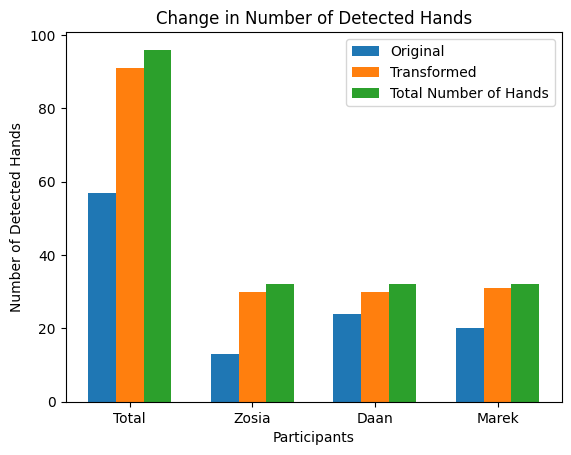

In [99]:
# Plot the change in the number of detected hands total, and then for each participant all on one plot

import matplotlib.pyplot as plt

participants = ["Total", "Zosia", "Daan", "Marek"]
original_hands = [total_original_hands, original_hands_p1, original_hands_p2, original_hands_p3]
transformed_hands = [total_transformed_hands, transformed_hands_p1, transformed_hands_p2, transformed_hands_p3]
total_number_of_images = [total_images, total_images_p1, total_images_p2, total_images_p3]

fig, ax = plt.subplots()

bar_width = 0.35
gap_size = 0.5

# Create an index with gaps between participants
index = np.arange(len(participants)) * (3 * bar_width + gap_size)

bar1 = ax.bar(index, original_hands, bar_width, label='Original')
bar2 = ax.bar(index + bar_width, transformed_hands, bar_width, label='Transformed')
bar3 = ax.bar(index + 2*bar_width, total_number_of_images, bar_width, label='Total Number of Hands')

ax.set_xlabel('Participants')
ax.set_ylabel('Number of Detected Hands')
ax.set_title('Change in Number of Detected Hands')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(participants)
ax.legend()

plt.show()




In [102]:
import matplotlib.pyplot as plt

# Threshold for significant difference
threshold = 0.01

# Calculate counts
decreased_count = sum(1 for orig, trans in zip(original_avg_distances, transformed_avg_distances) if orig - trans > threshold)
increased_count = sum(1 for orig, trans in zip(original_avg_distances, transformed_avg_distances) if trans - orig > threshold)
unchanged_count = len(original_avg_distances) - decreased_count - increased_count

# Pie chart
labels = ['Decreased', 'Increased', 'Unchanged']
sizes = [decreased_count, increased_count, unchanged_count]
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Percentage of Images with Decreased, Increased, and Unchanged Distances')
plt.show()


ValueError: cannot convert float NaN to integer

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ValueError: need at least one array to concatenate

<Figure size 600x600 with 1 Axes>

In [103]:
upper_bound_accuracy

82.07609386112142

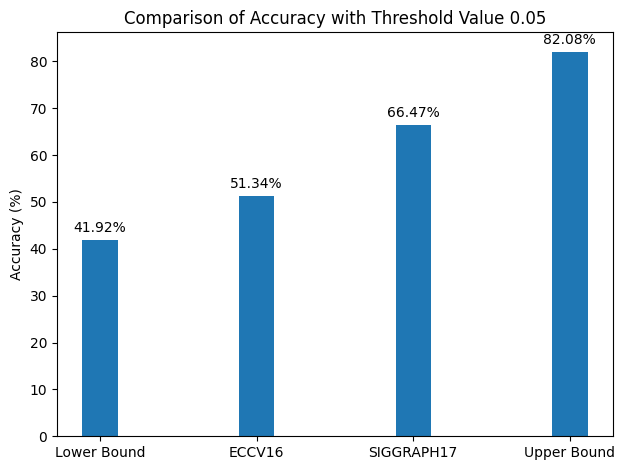

In [159]:
import matplotlib.pyplot as plt
import numpy as np  # Don't forget to import numpy if not already done

participants = ["Lower Bound", "ECCV16", "SIGGRAPH17", "Upper Bound"]
accuracies = [lower_bound_accuracy, transformed_accuracy_eccv16, transformed_accuracy_siggraph17, upper_bound_accuracy]

# Plot setup
fig, ax = plt.subplots()

bar_width = 0.35
gap_size = 0.5

# Create an index with gaps between participants
index = np.arange(len(participants)) * (3 * bar_width + gap_size)

# Define colors for the bars
# colors = ["blue" if i in [0, 3] else "orange" for i in range(len(participants))]

# Create the bars
bars = ax.bar(index, accuracies, bar_width)

# Add accuracy values above the bars
for i, bar in enumerate(bars):
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate: center of the bar
        bar.get_height() + 1,               # y-coordinate: slightly above the bar
        f"{accuracies[i]:.2f}%",               # Text to display
        ha="center", va="bottom", fontsize=10  # Alignment and font size
    )

# Set labels and title
ax.set_ylabel('Accuracy (%)')
ax.set_title('Comparison of Accuracy with Threshold Value 0.05')

# Set x-axis ticks and labels
ax.set_xticks(index)
ax.set_xticklabels(participants)

# Show plot
plt.tight_layout()
plt.show()


In [114]:
import os
import json

def calculate_bound_distances(image_directory, ground_truth_directory):
    total_bound = []
    for file_name in os.listdir(ground_truth_directory):
        if file_name.endswith('.json'):
            json_file_path = os.path.join(ground_truth_directory, file_name)
            
            with open(json_file_path, 'r') as f:
                ground_truth_data = json.load(f)
                
            for entry in ground_truth_data:
                image_name = entry["image"]
                ground_truth_landmarks = entry["landmarks"]
                image_path = os.path.join(image_directory, image_name)
    
                distances = calculate_distances_for_image(image_path, ground_truth_landmarks)
                total_bound.append(distances)
            
    return total_bound

In [115]:
lower_bound_distances = calculate_bound_distances(IR_image_directory, IR_ground_truth_directory)
upper_bound_distances = calculate_bound_distances(RGB_image_directory, RGB_ground_truth_directory)

Only one hand detected
Only one hand detected
Only one hand detected
Only one hand detected
Only one hand detected
Only one hand detected
Only one hand detected
Only one hand detected
Only one hand detected
Only one hand detected
Only one hand detected
Only one hand detected
Only one hand detected


In [119]:
def compute_statistics(distance_data, penalty_value=None):
    # Flatten the list of lists
    all_distances = [dist for image in distance_data for dist in image]
    
    # Filter out penalty values if provided
    valid_distances = all_distances if penalty_value is None else [dist for dist in all_distances if dist != penalty_value]
    
    # Compute statistics
    mean = np.mean(valid_distances)
    median = np.median(valid_distances)
    std_dev = np.std(valid_distances)
    min_dist = np.min(valid_distances)
    max_dist = np.max(valid_distances)
    
    return mean, median, std_dev, min_dist, max_dist

In [151]:
datasets = {
    "Lower Bound": lower_bound_distances,
    "SIGGRAPH17": total_distances_siggaph17,
    "ECCV16": total_distances_siggaph17,
    "Upper Bound": upper_bound_distances
}

In [152]:
penalty_value = None

In [153]:
statistics = {
    name: compute_statistics(data)
    for name, data in datasets.items()
}

In [154]:
for name, stats in statistics.items():
    print(f"{name}:")
    print(f"  Mean: {stats[0]:.3f}")
    print(f"  Median: {stats[1]:.3f}")
    print(f"  Std Dev: {stats[2]:.3f}")
    print(f"  Min: {stats[3]:.3f}")
    print(f"  Max: {stats[4]:.3f}")
    print()

Lower Bound:
  Mean: 0.416
  Median: 0.024
  Std Dev: 0.483
  Min: 0.000
  Max: 1.000

SIGGRAPH17:
  Mean: 0.068
  Median: 0.012
  Std Dev: 0.219
  Min: 0.000
  Max: 1.000

ECCV16:
  Mean: 0.068
  Median: 0.012
  Std Dev: 0.219
  Min: 0.000
  Max: 1.000

Upper Bound:
  Mean: 0.009
  Median: 0.007
  Std Dev: 0.007
  Min: 0.000
  Max: 0.047



In [155]:
# Visualize statistics
means = [stats[0] for stats in statistics.values()]
medians = [stats[1] for stats in statistics.values()]
std_devs = [stats[2] for stats in statistics.values()]
categories = list(statistics.keys())


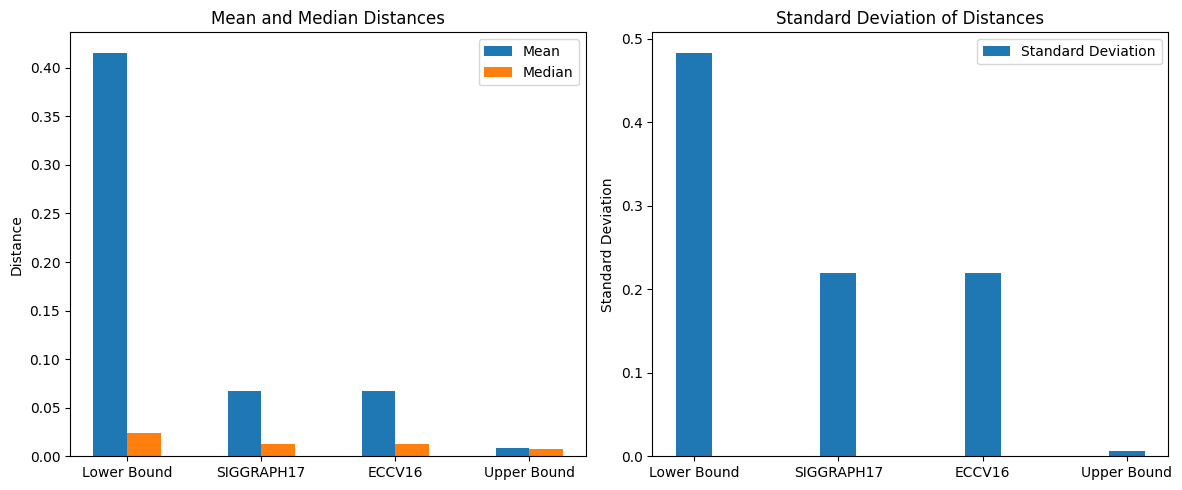

In [156]:
x = np.arange(len(categories))  # X-axis positions
width = 0.25  # Width of the bars

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot means and standard deviations
ax[0].bar(x - width/2, means, width, label='Mean')
ax[0].bar(x + width/2, medians, width, label='Median')
ax[0].set_title("Mean and Median Distances")
ax[0].set_xticks(x)
ax[0].set_xticklabels(categories)
ax[0].set_ylabel("Distance")
ax[0].legend()

# Plot standard deviation
ax[1].bar(x, std_devs, width, label='Standard Deviation')
ax[1].set_title("Standard Deviation of Distances")
ax[1].set_xticks(x)
ax[1].set_xticklabels(categories)
ax[1].set_ylabel("Standard Deviation")
ax[1].legend()

# Improve layout
plt.tight_layout()

# Show plots
plt.show()

In [167]:
zosia_results["accuracy_siggaph17"]["Left"]

[69.47171187749174,
 73.67109228030837,
 78.70217977389488,
 86.05006476772343,
 76.7705076685402,
 64.51007916159372,
 71.12015651003743,
 63.845244091870754,
 85.60615018944945,
 60.18223239208227,
 55.33503773932824,
 37.01655251385484,
 74.39035526109362,
 40.49089234054682,
 90.92891802134467,
 58.303274756241166,
 87.68882414318601,
 84.66301361965667,
 95.87186015077133,
 84.45316033236632,
 90.38246332626595,
 64.98199254886966,
 88.96103385814213,
 92.56504912131004,
 92.29444759957424,
 90.60739970454131,
 76.8571745741797,
 73.40523143179338,
 66.85149063854384,
 99.24567737414128,
 80.84702755866485,
 53.69706034432713,
 45.350375804373165,
 95.85854793462939,
 69.58143867795053,
 89.16850007416743,
 83.02599777777291,
 85.30037394583486,
 68.99139929380547,
 90.93862035282532,
 91.34717160936748,
 84.9052015453263,
 83.81444683005273,
 78.0162754420415,
 87.51015015563735,
 84.8448654936026,
 85.10731834241449,
 95.77016909540103,
 53.18246919358609,
 66.31484134388094,
 9

In [168]:
zosia_transformed_accuracy_siggraph17 = calculate_final_accuracy(zosia_results["accuracy_siggaph17"])
zosia_transformed_accuracy_eccv16 = calculate_final_accuracy(zosia_results["accuracy_eccv16"])
daan_transformed_accuracy_siggraph17 = calculate_final_accuracy(daan_results["accuracy_siggaph17"])
daan_transformed_accuracy_eccv16 = calculate_final_accuracy(daan_results["accuracy_eccv16"])
marek_transformed_accuracy_siggraph17 = calculate_final_accuracy(marek_results["accuracy_siggaph17"])
marek_transformed_accuracy_eccv16 = calculate_final_accuracy(marek_results["accuracy_eccv16"])

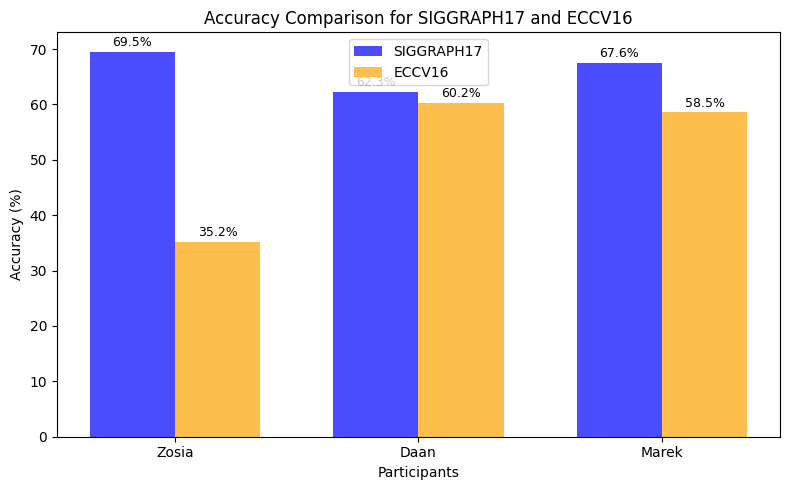

In [169]:
# Data for plotting
participants = ["Zosia", "Daan", "Marek"]
siggraph17_accuracies = [
    zosia_transformed_accuracy_siggraph17,
    daan_transformed_accuracy_siggraph17,
    marek_transformed_accuracy_siggraph17,
]
eccv16_accuracies = [
    zosia_transformed_accuracy_eccv16,
    daan_transformed_accuracy_eccv16,
    marek_transformed_accuracy_eccv16,
]

x = np.arange(len(participants))  # X-axis positions
width = 0.35  # Bar width

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot bars for SIGGRAPH17 and ECCV16
bar1 = ax.bar(x - width/2, siggraph17_accuracies, width, label="SIGGRAPH17", color="blue", alpha=0.7)
bar2 = ax.bar(x + width/2, eccv16_accuracies, width, label="ECCV16", color="orange", alpha=0.7)

# Add labels, title, and legend
ax.set_xlabel("Participants")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Accuracy Comparison for SIGGRAPH17 and ECCV16")
ax.set_xticks(x)
ax.set_xticklabels(participants)
ax.legend()

# Annotate values above the bars
for bar in bar1 + bar2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{height:.1f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

In [170]:
# Average distances per model per participant
zosia_siggraph17_avg = np.mean(zosia_results["distance_siggaph17"])
daan_siggraph17_avg = np.mean(daan_results["distance_siggaph17"])
marek_siggraph17_avg = np.mean(marek_results["distance_siggaph17"])

zosia_eccv16_avg = np.mean(zosia_results["distance_eccv16"])
daan_eccv16_avg = np.mean(daan_results["distance_eccv16"])
marek_eccv16_avg = np.mean(marek_results["distance_eccv16"])

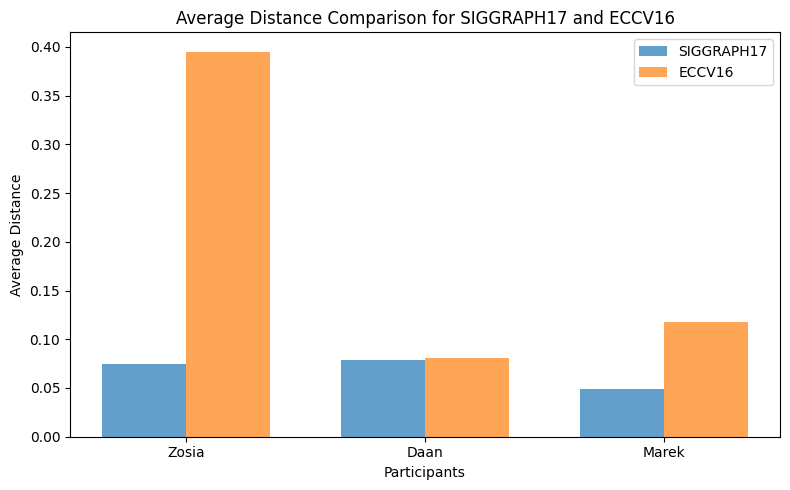

In [171]:
# Plot the distances

# Data for plotting
participants = ["Zosia", "Daan", "Marek"]
siggraph17_avg_distances = [zosia_siggraph17_avg, daan_siggraph17_avg, marek_siggraph17_avg]
eccv16_avg_distances = [zosia_eccv16_avg, daan_eccv16_avg, marek_eccv16_avg]

x = np.arange(len(participants))  # X-axis positions
width = 0.35  # Bar width

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot bars for SIGGRAPH17 and ECCV16
bar1 = ax.bar(x - width/2, siggraph17_avg_distances, width, label="SIGGRAPH17", alpha=0.7)
bar2 = ax.bar(x + width/2, eccv16_avg_distances, width, label="ECCV16", alpha=0.7)

# Add labels, title, and legend 
ax.set_xlabel("Participants")
ax.set_ylabel("Average Distance")
ax.set_title("Average Distance Comparison for SIGGRAPH17 and ECCV16")
ax.set_xticks(x)
ax.set_xticklabels(participants)
ax.legend()

plt.tight_layout()
plt.show()


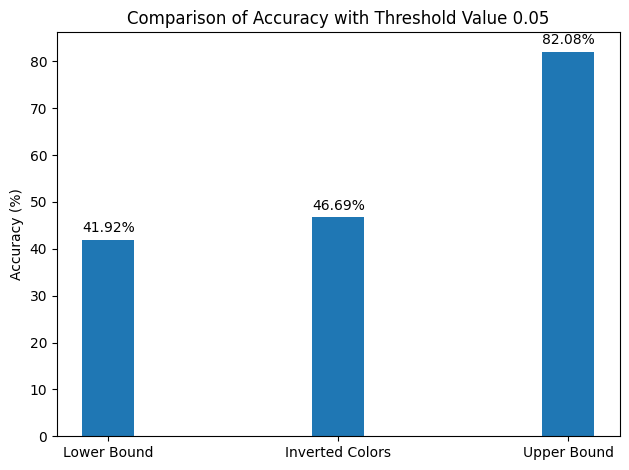

In [112]:
# Plot lower bound, upper bound, transformed ECCV16, and transformed SIGGRAPH17 accuracies
participants = ["Lower Bound", "Inverted Colors", "Upper Bound",]
accuracies = [lower_bound_accuracy, inverted_accuracy, upper_bound_accuracy]

# Plot setup
fig, ax = plt.subplots()

bar_width = 0.35
gap_size = 0.5

# Create an index with gaps between participants
index = np.arange(len(participants)) * (3 * bar_width + gap_size)

# Create the bars
bars = ax.bar(index, accuracies, bar_width)

# Add accuracy values above the bars
for i, bar in enumerate(bars):
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate: center of the bar
        bar.get_height() + 1,               # y-coordinate: slightly above the bar
        f"{accuracies[i]:.2f}%",               # Text to display
        ha="center", va="bottom", fontsize=10  # Alignment and font size
    )
    
# Set labels and title
ax.set_ylabel('Accuracy (%)')
ax.set_title('Comparison of Accuracy with Threshold Value 0.05')

# Set x-axis ticks and labels
ax.set_xticks(index)
ax.set_xticklabels(participants)

# Show plot
plt.tight_layout()
plt.show()